In this notebook we load our complete dataset (`all_data.csv`) which includes all behavioural and political variables. We then remove participants who filled out these questionnaires but have no corresponding BOLD scan. We are then left with 854 participants. 
We then split our data into two halves at random and run the appropriate tests to ensure that the two samples  are not significantly different, and we plot the outcomes.

In the following code we setup the notebook for analysis, including loading all necessary packages, defining directories and importing all (political) data. 

In [1]:
# packages
import os
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# directories
data_directory = os.path.dirname("/home/c13572687/Documents/scripts_and_data/csv_data/")
saving_directory = os.path.dirname("/home/c13572687/Documents/scripts_and_data/figures/split_half_graphs/")
 
# loading data
all_data = pd.read_csv(str(data_directory + "/all_data.csv")).iloc[:,1:12]

We need to download the BOLD data of all participants who watched the clip.

In [ ]:
# download relevant data from dataset in bulk
aws s3 sync --no-sign-request s3://openneuro.org/ds003097 '/home/c13572687/Documents/scripts_and_data/fmri_data' --exclude "*" --include "sub-*/func/*moviewatching_bold.nii.gz"

In the following cell we loop over our participants and attempt to load the BOLD data for each. When the loop encounters an error it adds the participant number to a numpy array named `no_bold_scan` so that we can then `drop` all these participants from `all_data` such that we are left with 854 participants, each of whom has a BOLD scan and filled out all relevant questionnaires.

In [ ]:
not_there = 0
no_bold_scan = np.array([])
for subject in range(all_data.shape[0]):
  try:
    fmri_filename = os.path.join(fmri_directory, exploratory_data['participant_id'][subject], 'func', str(exploratory_data['participant_id'][subject] + '_task-moviewatching_bold.nii.gz'))
    img = nib.load(fmri_filename)
    data = img.get_fdata() # (42, 64, 54, 290)

  # if there is some missing data, e.g., subject 9 didn't watch the movie the following block keeps the loop 
  # running despite the error it gets from looking for a non-existant file
  except:
    print(exploratory_data['participant_id'][subject], '- not there')
    not_there += 1
    no_bold_scan = np.append(no_bold_scan, exploratory_data['participant_id'][subject])
    continue
    
# these are the participants with no BOLD scan
#no_bold_scan = np.array(['sub-0358', 'sub-0749', 'sub-0093', 'sub-0720', 'sub-0144', 'sub-0928', 'sub-0370', 'sub-0488', 'sub-0827', 'sub-0770', 'sub-0403', 'sub-0755', 'sub-0216', 'sub-0580', 'sub-0360', 'sub-0009', 'sub-0663', 'sub-0201', 'sub-0804', 'sub-0876', 'sub-0177', 'sub-0346', 'sub-0348', 'sub-0733', 'sub-0824', 'sub-0019', 'sub-0020', 'sub-0023', 'sub-0026', 'sub-0028', 'sub-0101', 'sub-0299', 'sub-0321', 'sub-0383', 'sub-0387', 'sub-0435', 'sub-0476', 'sub-0528', 'sub-0568', 'sub-0726', 'sub-0729', 'sub-0743', 'sub-0768', 'sub-0795', 'sub-0821', 'sub-0902'])

for participant in range(len(all_data['participant_id'])):
  if all_data['participant_id'][participant] in no_bold_scan:
    all_data = all_data.drop([participant], axis = 0)

The next cell creates two samples out of our current large sample. The cell after loads existing split-half data (in a scenario where we use this script to re-examine our existing split-samples rather than creating new ones).

In [1]:
exploratory_half = all_data.sample(frac = 0.5)
confirmatory_half = all_data.drop(exploratory_half.index)

len(exploratory_half) == len(confirmatory_half) # they are the same length

In [2]:
exploratory_half = pd.read_csv(str(data_directory + "/exploratory_half.csv"), sep = ',')
confirmatory_half = pd.read_csv(str(data_directory + "/confirmatory_half.csv"), sep = ',')

The following cell compares our two samples on the bases of six variables. For each, we run an approproate test to ensure that there are no differences, and then we plot three distributions: the full sample and each smaller sample along with the _p_-value of the relevant test.

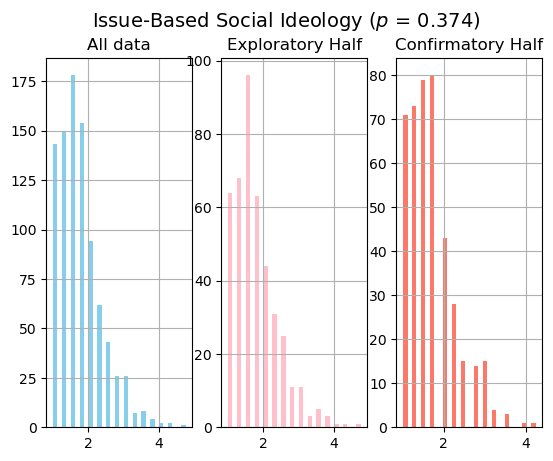

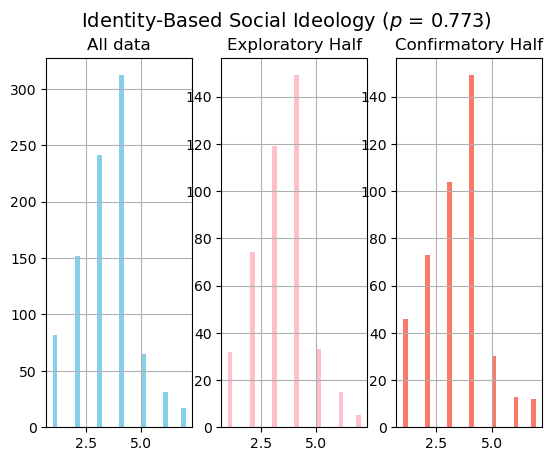

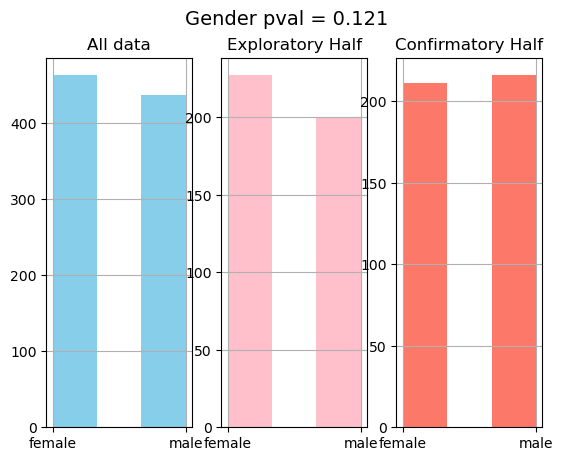

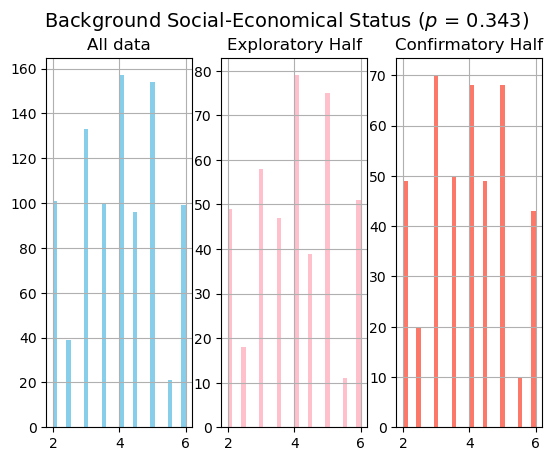

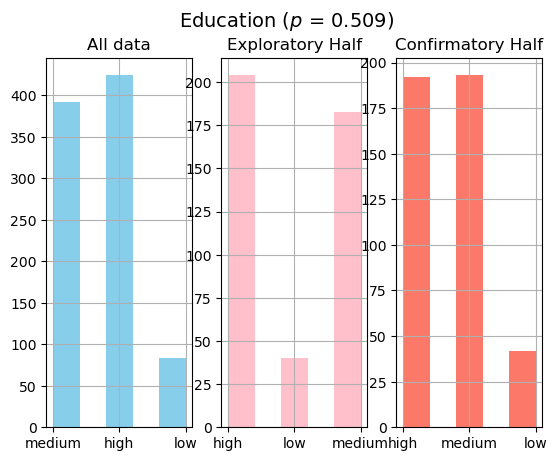

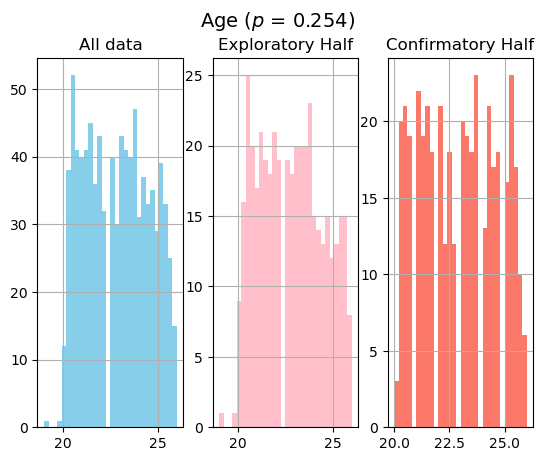

In [3]:
# we'll compare the i/d.v.'s (column name in bracket):

# (i) issue-based social ideology (social.ideology)

pval = str(round(stats.ttest_ind(exploratory_half['social.ideology'], confirmatory_half['social.ideology']).pvalue,3))
title = str('Issue-Based Social Ideology ($p$ = '+ pval+ ")")

fig, axs = plt.subplots(1, 3)
fig.suptitle(title, fontsize = 14)

all_data['social.ideology'].hist(bins=30, ax=axs[0], color = "skyblue")
exploratory_half['social.ideology'].hist(bins=30, ax=axs[1], color = "pink")
confirmatory_half['social.ideology'].hist(bins=30, ax=axs[2], color = '#FC7869')

axs[0].title.set_text('All data')
axs[1].title.set_text('Exploratory Half')
axs[2].title.set_text('Confirmatory Half')

plt.savefig(os.path.join(saving_directory + '/issue-ideology-split.png'), dpi = 500)

plt.show()

# (ii) identity-based social ideology (social.identity)

pval = str(round(stats.ttest_ind(exploratory_half['social.identity'], confirmatory_half['social.identity']).pvalue,3))
title = str('Identity-Based Social Ideology ($p$ = '+ pval+ ")")

fig, axs = plt.subplots(1, 3)
fig.suptitle(title, fontsize = 14)

all_data['social.identity'].hist(bins=30, ax=axs[0], color = "skyblue")
exploratory_half['social.identity'].hist(bins=30, ax=axs[1], color = "pink")
confirmatory_half['social.identity'].hist(bins=30, ax=axs[2], color = '#FC7869')

axs[0].title.set_text('All data')
axs[1].title.set_text('Exploratory Half')
axs[2].title.set_text('Confirmatory Half')

plt.savefig(os.path.join(saving_directory + '/identity-ideology-split.png'), dpi = 500)

plt.show()

# (iii) gender (sex)

exp = np.append(list(confirmatory_half['sex']).count('male'), list(confirmatory_half['sex']).count('female'))
obs = np.append(list(exploratory_half['sex']).count('male'), list(exploratory_half['sex']).count('female'))

pval = str(round(stats.chisquare(obs, exp, axis = None).pvalue,3))
title = str('Gender pval = '+ pval)

fig, axs = plt.subplots(1, 3)
fig.suptitle(title, fontsize = 14)

all_data['sex'].hist(bins=3, ax=axs[0], color = "skyblue")
exploratory_half['sex'].hist(bins=3, ax=axs[1], color = "pink")
confirmatory_half['sex'].hist(bins=3, ax=axs[2], color = '#FC7869')

axs[0].title.set_text('All data')
axs[1].title.set_text('Exploratory Half')
axs[2].title.set_text('Confirmatory Half')

plt.savefig(os.path.join(saving_directory + '/gender-split.png'), dpi = 500)

plt.show()

# (iv) SES (background_SES)

exp = np.append(list(exploratory_half['background_SES']).count(2), (list(exploratory_half['background_SES']).count(2.5), list(exploratory_half['background_SES']).count(3), list(exploratory_half['background_SES']).count(3.5), list(exploratory_half['background_SES']).count(4), list(exploratory_half['background_SES']).count(4.5), list(exploratory_half['background_SES']).count(5), list(exploratory_half['background_SES']).count(5.5),list(exploratory_half['background_SES']).count(6)))
obs = np.append(list(confirmatory_half['background_SES']).count(2), (list(confirmatory_half['background_SES']).count(2.5), list(confirmatory_half['background_SES']).count(3), list(confirmatory_half['background_SES']).count(3.5), list(confirmatory_half['background_SES']).count(4), list(confirmatory_half['background_SES']).count(4.5), list(confirmatory_half['background_SES']).count(5), list(confirmatory_half['background_SES']).count(5.5),list(confirmatory_half['background_SES']).count(6)))

pval = str(round(stats.chisquare(obs, exp, axis = None).pvalue,3))
title = str('Background Social-Economical Status ($p$ = '+ pval+ ")")

fig, axs = plt.subplots(1, 3)
fig.suptitle(title, fontsize = 14)

all_data['background_SES'].hist(bins=30, ax=axs[0], color = "skyblue")
exploratory_half['background_SES'].hist(bins=30, ax=axs[1], color = "pink")
confirmatory_half['background_SES'].hist(bins=30, ax=axs[2], color = '#FC7869')

axs[0].title.set_text('All data')
axs[1].title.set_text('Exploratory Half')
axs[2].title.set_text('Confirmatory Half')

fig.suptitle(title, fontsize = 14)

plt.savefig(os.path.join(saving_directory + '/background_SES-split.png'), dpi = 500)

plt.show()

# (v) education level (education_level)

all_data['education_level'] = all_data['education_level'].astype('category')
all_data['education_level'].cat.reorder_categories(['low', 'medium', 'high'])
exploratory_half['education_level'] = exploratory_half['education_level'].astype('category')
exploratory_half['education_level'].cat.reorder_categories(['low', 'medium', 'high'])
confirmatory_half['education_level'] = confirmatory_half['education_level'].astype('category')
confirmatory_half['education_level'].cat.reorder_categories(['low', 'medium', 'high'])

exp = np.append(list(exploratory_half['education_level']).count("low"), (list(exploratory_half['education_level']).count("medium"), list(exploratory_half['education_level']).count("high")))
obs = np.append(list(confirmatory_half['education_level']).count("low"), (list(confirmatory_half['education_level']).count("medium"), list(confirmatory_half['education_level']).count("high")))

pval = str(round(stats.chisquare(obs, exp, axis = None).pvalue,3))
title = str('Education ($p$ = '+ pval+ ")")

fig, axs = plt.subplots(1, 3)
fig.suptitle(title, fontsize = 14)

all_data['education_level'].hist(bins=5, ax=axs[0], color = "skyblue")
exploratory_half['education_level'].hist(bins=5, ax=axs[1], color = "pink")
confirmatory_half['education_level'].hist(bins=5, ax=axs[2], color = '#FC7869')

axs[0].title.set_text('All data')
axs[1].title.set_text('Exploratory Half')
axs[2].title.set_text('Confirmatory Half')

fig.suptitle(title, fontsize = 14)

plt.savefig(os.path.join(saving_directory + '/education-split.png'), dpi = 500)

plt.show()

# (vi) age

# while not a variable in the analysis, probably good to check anyway

pval = str(round(stats.ttest_ind(exploratory_half['age'], confirmatory_half['age']).pvalue,3))
title = str('Age ($p$ = '+ pval+ ")")

fig, axs = plt.subplots(1, 3)
all_data['age'].hist(bins=30, ax=axs[0], color = "skyblue")
exploratory_half['age'].hist(bins=30, ax=axs[1], color = "pink")
confirmatory_half['age'].hist(bins=30, ax=axs[2], color = '#FC7869')

axs[0].title.set_text('All data')
axs[1].title.set_text('Exploratory Half')
axs[2].title.set_text('Confirmatory Half')

fig.suptitle(title, fontsize = 14)

plt.savefig(os.path.join(saving_directory + '/age-split.png'), dpi = 500)

plt.show()

# saving halves ----------------------------------------------------------------

exploratory_half.to_csv(str(str(data_directory) + '/exploratory_half.csv'), index=False)
confirmatory_half.to_csv(str(str(data_directory) + '/confirmatory_half.csv'), index=False)